In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import calendar
import quantstats as qs

In [2]:
STARTING_DAY = datetime.datetime(1989, 1, 1)
FIRST_ACTION_DAY = datetime.datetime(1994, 1, 1)

In [3]:
ew_weights = pd.read_csv('data/ew_weights.csv', index_col=0)
min_variance_weights = pd.read_csv('data/min_variance_weights.csv', index_col=0)
ew_weights.index = pd.to_datetime(ew_weights.index)
min_variance_weights.index = pd.to_datetime(min_variance_weights.index)

In [4]:
selected_stocks = pd.read_excel('data/selected_stocks.xlsx')

# Download prices
symbols = selected_stocks['Symbol'].tolist()
prices = yf.download(symbols)

# Exclude data before STARTING DAY
prices = prices.loc[STARTING_DAY:]

# Separate variables
adj_close_df = prices['Adj Close']
close_df = prices['Close']
open_df = prices['Open']

adj_close_returns = utils.compute_returns(adj_close_df)
close_returns = utils.compute_returns(close_df)
open_returns = utils.compute_returns(open_df)

[*********************100%%**********************]  11 of 11 completed


In [5]:
action_days = ew_weights.index

# Monthly returns

In [6]:
ew_strategy_monthly_returns = []
min_variance_strategy_monthly_returns = []
for i in range(len(action_days) - 1):
    start = action_days[i]
    end = action_days[i+1] - datetime.timedelta(days=1)  # End is included
    stocks_returns_in_period = adj_close_returns.loc[start:end]
    w_ew = ew_weights.loc[start]
    w_min_var = min_variance_weights.loc[start]
    ew_strategy_monthly_returns.append(
        utils.compute_single_period_returns(stocks_returns_in_period, w_ew).sum(axis=1).iloc[-1] - 1)
    min_variance_strategy_monthly_returns.append(
        utils.compute_single_period_returns(stocks_returns_in_period, w_min_var).sum(axis=1).iloc[-1] - 1)

In [7]:
df_strategy_monthly = pd.DataFrame(
    {
        'ew_strategy': ew_strategy_monthly_returns,
        'min_variance_strategy': min_variance_strategy_monthly_returns
    },
    index=action_days[1:])

In [8]:
month_dict = dict((v, k) for k, v in enumerate(calendar.month_name))
ew_ret_table = pd.DataFrame(df_strategy_monthly.loc[:'2024-01'].iloc[:, 0].values.reshape(-1, 12),
                            index=pd.Series(range(1994, 2024), name='Year'),
                            columns=list(month_dict.keys())[1:])

min_var_ret_table = pd.DataFrame(df_strategy_monthly.loc[:'2024-01'].iloc[:, 1].values.reshape(-1, 12),
                                 index=pd.Series(range(1994, 2024), name='Year'),
                                 columns=list(month_dict.keys())[1:])

In [9]:
# Save tables
ew_ret_table.to_excel('data/ew_monthly_returns.xlsx')
min_var_ret_table.to_excel('data/min_var_monthly_returns.xlsx')

In [10]:
plt.style.use('ggplot')
colors = sns.color_palette('Paired', 4)

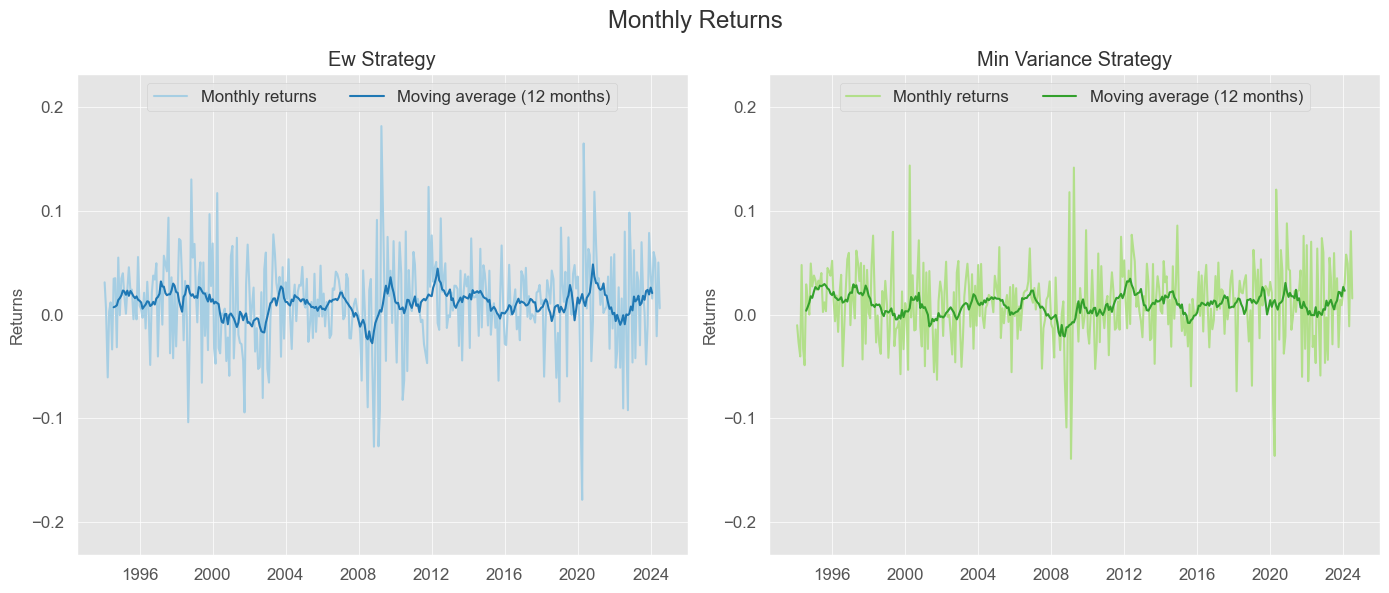

In [11]:
df = df_strategy_monthly

fig1, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

limit = np.max(np.abs(df.values)).item()
delta = 0.05
rolling_window = 12
for i in range(len(df.columns)):
    # Plot monthly returns
    axes[i].plot(df.iloc[:, i], label=f'Monthly returns', color=colors[i*2])
    # Set same scale
    axes[i].set_ylim((-(limit + delta), limit + delta))
    # Plot moving average
    axes[i].plot(df.iloc[:, i].rolling(rolling_window, center=True).mean(),
                 label=f'Moving average ({rolling_window} months)', color=colors[i*2 + 1])
    axes[i].legend(ncol=2, loc='upper center')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    axes[i].set_ylabel('Returns')
fig1.suptitle(f'Monthly Returns', fontsize='xx-large')
plt.savefig('plots/monthly_returns_ew_vs_min_var.png')
plt.show()

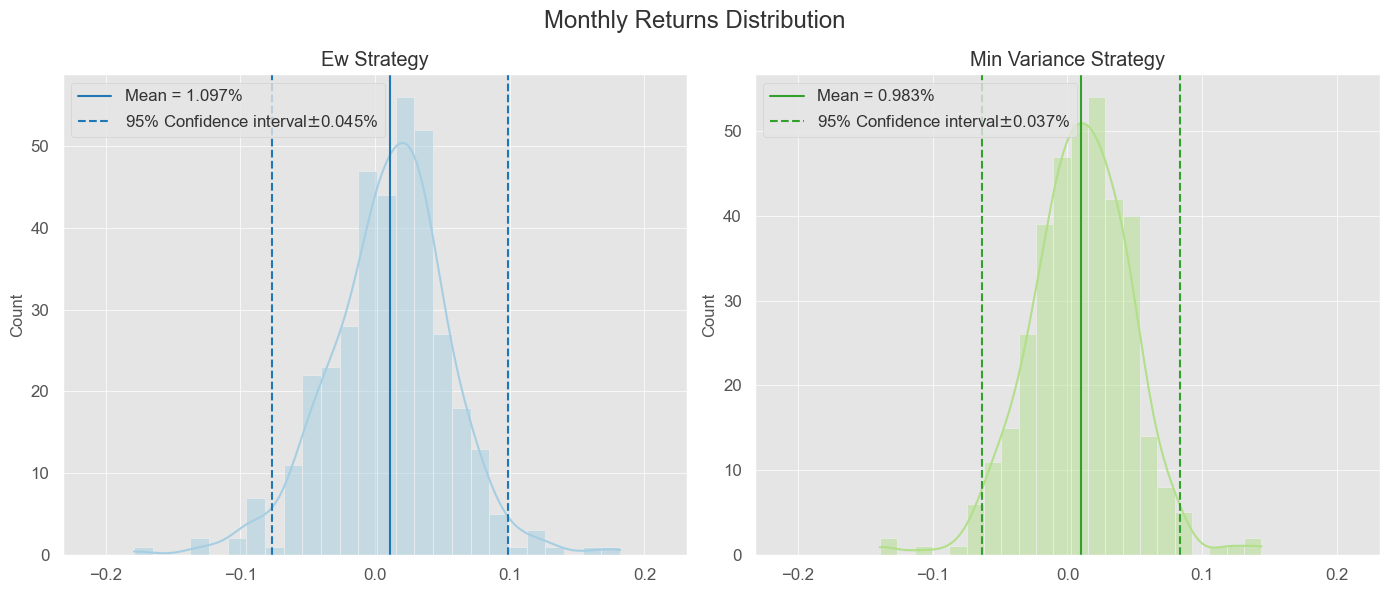

In [12]:
fig2, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for i in range(len(df.columns)):
    sns.histplot(df.iloc[:, i], ax=axes[i], color=colors[i*2], kde=True)
    axes[i].set_xlim((-(limit + delta), limit + delta))
    axes[i].set_xlabel('')
    axes[i].set_title(f'{df.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    mu = df.iloc[:, i].mean()
    sd = df.iloc[:, i].std()
    ci = ((mu - 1.96*sd).item(), (mu + 1.96*sd).item())
    axes[i].axvline(mu, label=f'Mean = {100*mu:.3f}%', color=colors[i*2 + 1])
    axes[i].axvline(ci[0], label=f'95% Confidence interval' + r'$\pm$' + f'{np.round(sd, 3)}%', color=colors[i*2 + 1], ls='--')
    axes[i].axvline(ci[1], color=colors[i*2 + 1], ls='--')

    axes[i].legend()
fig2.suptitle(f'Monthly Returns Distribution', fontsize='xx-large')
plt.savefig('plots/monthly_returns_distribution_ew_vs_min_var.png')
plt.show()

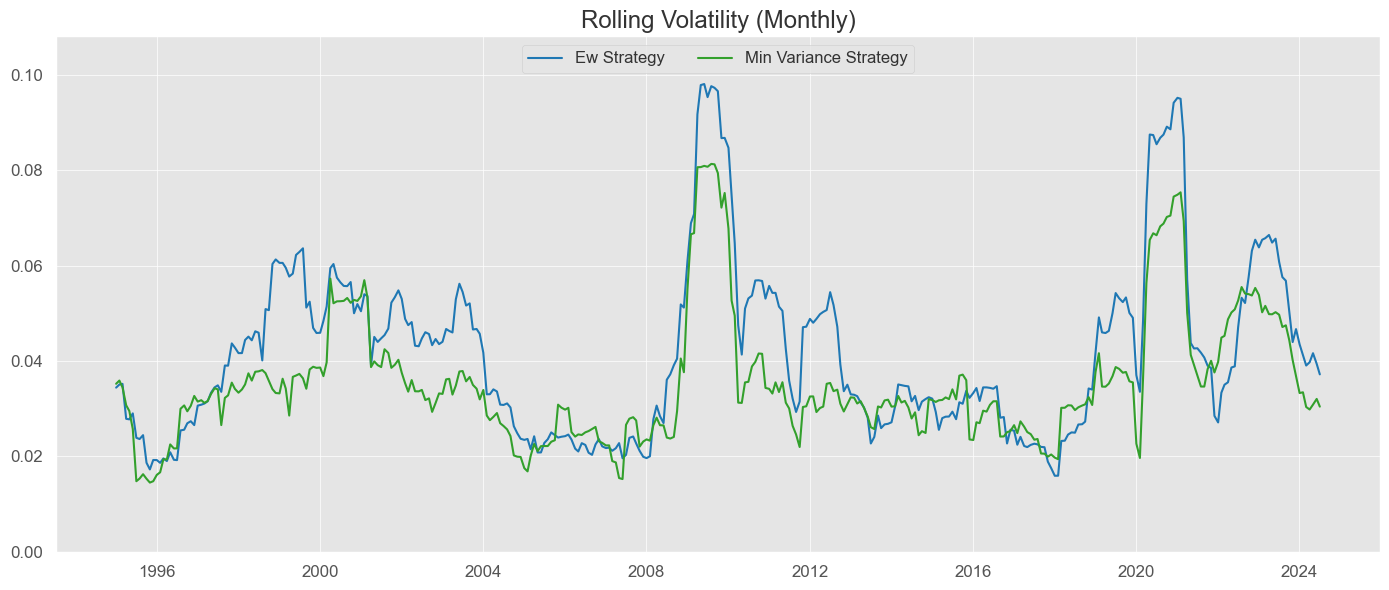

In [13]:
fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
ymax = 0
delta = 0.01
for i in range(len(df.columns)):
    x = df.iloc[:, i].rolling(rolling_window, center=False).std()
    ax.plot(x, label=f'{df.columns[i].replace("_", " ").title()}', color=colors[i*2 + 1])
    ymax = np.max((ymax, np.max(x)))
ax.set_ylim((0, ymax + delta))
ax.legend(ncols=2, loc='upper center', fontsize='large')
ax.set_title(f'Rolling Volatility (Monthly)', fontsize='xx-large')

plt.show()

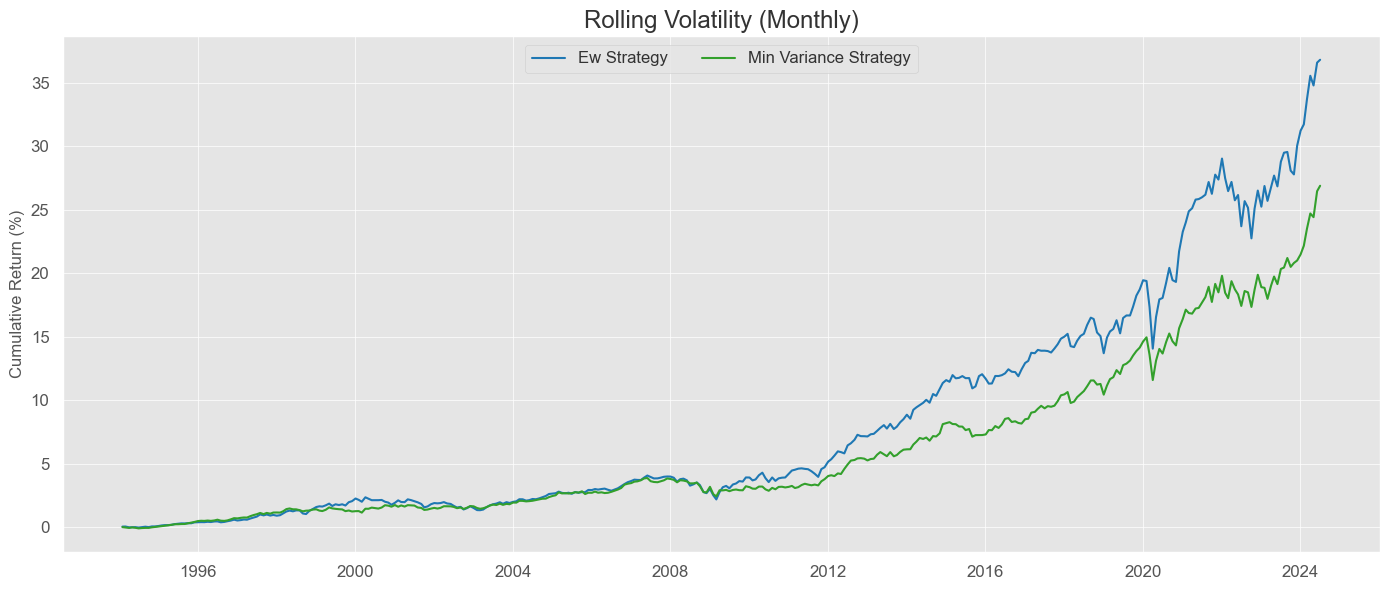

In [14]:
df_strategy_cumret = (df + 1).cumprod() - 1
fig4, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for i in range(len(df_strategy_cumret.columns)):
    x = df_strategy_cumret.iloc[:, i]
    ax.plot(x, label=f'{df.columns[i].replace("_", " ").title()}', color=colors[i*2 + 1])
ax.set_ylabel('Cumulative Return (%)')
ax.legend(ncols=2, loc='upper center', fontsize='large')
ax.set_title(f'Rolling Volatility (Monthly)', fontsize='xx-large')
plt.show()